# Input training and testing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = np.load('./Data/Closing_Price.npy')
Y = np.load('./Data/Trading_Volume.npy')
Day_Split = 300
# X_Train:(487, 300), Y_Train:(1, 300), X_Test:(487, 165), Y_Test:(1, 165)
X_Train, X_Test = X[:, :Day_Split], X[:, Day_Split:]
Y_Train, Y_Test = Y[:, :Day_Split], Y[:, Day_Split:]

In [2]:
X_Train_mu = np.mean(X_Train, axis=1, keepdims=True)
X_Train_sigma = np.std(X_Train, axis=1, keepdims=True)
Y_Train_mu = np.mean(Y_Train, axis=1)
Y_Train_sigma = np.std(Y_Train, axis=1)
# X_Test_mu = np.mean(X_Train, axis=1, keepdims=True)
# X_Test_sigma = np.std(X_Train, axis=1, keepdims=True)
# Y_Test_mu = np.mean(Y_Train, axis=1)
# Y_Test_sigma = np.std(Y_Train, axis=1)

In [3]:
# Data Scaling and Output as 2 csv FILE for C++
X_Train_Scaled = (X_Train - X_Train_mu) / X_Train_sigma
Y_Train_Scaled = (Y_Train - Y_Train_mu) / Y_Train_sigma
np.savetxt('X_Train_Scaled.csv', X_Train_Scaled, delimiter=",")
np.savetxt('Y_Train_Scaled.csv', Y_Train_Scaled, delimiter=",")

# Train a three-layer neural network

In [4]:
# Network Architecture
training_epochs = 5000
# number of training examples
m = X_Train.shape[1]
# number of neurons in the input layer
n_input = X_Train.shape[0]
# number of neurons in layer 1
n_hidden_1 = 50
# number of neurons in layer 2
n_hidden_2 = 5
# number of neurons in layer 3
n_hidden_3 = 1
#Initialization Weights Matrix W and Bias b
W1 = np.random.randn(n_hidden_1, n_input) * 0.1
W2 = np.random.randn(n_hidden_2, n_hidden_1) * 0.1
W3 = np.random.randn(n_hidden_3, n_hidden_2) * 0.1
b1 = np.zeros((n_hidden_1, 1))
b2 = np.zeros((n_hidden_2, 1))
b3 = np.zeros((n_hidden_3, 1))

In [5]:
def Relu(z):
    return np.maximum(z, 0.0)

def Relu_prime(z):
    x = np.zeros(z.shape)
    x[z>0] = 1
    x[z==0] = 0.5
    return x

def Cost_Function(y_predict, y):
    cost = (y_predict-y)**2
    cost = np.sum(cost)/y.shape[1]
#   This turns [[cost]] into cost
#   cost = np.squeeze(cost)
    return cost
    

In [6]:
def Three_Layer_Network_Training(X_Train, Y_Train, W1, W2, W3, b1, b2, b3, learning_rate=0.005):
    # Forward Propagation Algorithm
    m = X_Train.shape[1]
    A0 = X_Train
    Z1 = np.dot(W1, A0) + b1
    A1 = Relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = Relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = Relu(Z3)
    Fx = Cost_Function(A3, Y_Train)

    # Backward Propagation Algorithm
    dZ3 = 2 * (A3-Y_Train) * Relu_prime(Z3)
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m
    dA2 = np.dot(W3.T, dZ3)

    dZ2 = dA2 * Relu_prime(Z2)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dA1 = np.dot(W2.T, dZ2)

    dZ1 = dA1 * Relu_prime(Z1)
    dW1 = np.dot(dZ1, A0.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    # dA0 = np.dot(W1.T, dZ1)

    # Gradient Descent
    W1 = W1 - learning_rate*dW1
    W2 = W2 - learning_rate*dW2
    W3 = W3 - learning_rate*dW3
    b1 = b1 - learning_rate*db1
    b2 = b2 - learning_rate*db2
    b3 = b3 - learning_rate*db3
    return W1, W2, W3, b1, b2, b3, Fx

0 iterations cost is: 0.99004336
500 iterations cost is: 0.70801627
1000 iterations cost is: 0.62696286
1500 iterations cost is: 0.58176085
2000 iterations cost is: 0.54439934
2500 iterations cost is: 0.51685912
3000 iterations cost is: 0.49884153
3500 iterations cost is: 0.48743989
4000 iterations cost is: 0.48109780
4500 iterations cost is: 0.47694386


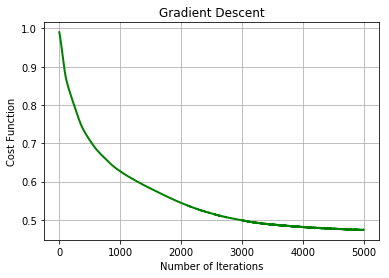

In [7]:
# Minimize Cost Function
Fx_array = np.zeros(training_epochs)
for iterations in range(training_epochs):
    W1, W2, W3, b1, b2, b3, Fx_array[iterations] = Three_Layer_Network_Training(X_Train_Scaled, Y_Train_Scaled, W1, W2, W3, b1, b2, b3)
    if iterations%500 == 0:
        print("%d iterations cost is: %.8f" % (iterations, Fx_array[iterations]))

# Plot the Graph
plt.plot(range(training_epochs), Fx_array, 'g-', linewidth=2.0)
plt.title('Gradient Descent')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Function')
plt.legend()
plt.grid(True)
plt.show()

# Predict the next day trading volume

In [8]:
def Predict_Function(X_Test, Y_Test, W1, W2, W3, b1, b2, b3):
    # Forward Propagation Algorithm
    A0 = X_Test
    Z1 = np.dot(W1, A0) + b1
    A1 = Relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = Relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = Relu(Z3)
    Y_Predict = A3
    Fx = Cost_Function(Y_Predict, Y_Test)
    print("The Test Cost is:", Fx)
    print("Mean Square Error * sigma^2 is:", Fx*Y_Train_sigma*Y_Train_sigma)
    return Y_Predict

The Test Cost is: 0.8794972496348974
Mean Square Error * sigma^2 is: [3.62233664e+17]


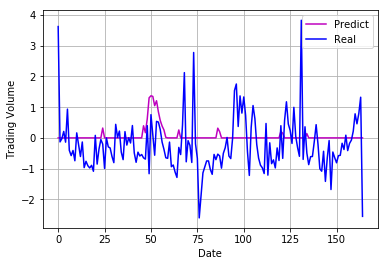

In [9]:
# Data Scaling
X_Test_Scaled = (X_Test - X_Train_mu) / X_Train_sigma
Y_Test_Scaled = (Y_Test - Y_Train_mu) / Y_Train_sigma
Y_Test_Hat = Predict_Function(X_Test_Scaled, Y_Test_Scaled, W1, W2, W3, b1, b2, b3)

# Scaled Back
Y_Test_Real = Y_Test_Hat * Y_Train_sigma + Y_Train_mu

# Plot the Graph
plt.plot(range(Y_Test_Hat.shape[1]), np.squeeze(Y_Test_Hat), 'm-', label='Predict')
plt.plot(range(Y_Test_Scaled.shape[1]), np.squeeze(Y_Test_Scaled), 'b-', label='Real')
plt.xlabel('Date')
plt.ylabel('Trading Volume')
plt.legend()
plt.grid(True)
plt.show()